In [340]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

In [350]:
# Load data
wikis=pd.read_csv('data/wikis')
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/gender.csv"
gendata = pd.read_csv(file)
# only wikipedia projects
gendata=gendata[gendata.wiki_db.isin(list(wikis['database_code']))]
gendata

,wiki_db,category,time_bucket,article_created_value,pageviews_sum_value,pageviews_mean_value,standard_quality_value,standard_quality_count_value,quality_score_value,revision_count_value,...,standard_quality_count_all_categories,quality_score_all_categories,revision_count_all_categories,article_created_all_wikis,pageviews_sum_all_wikis,pageviews_mean_all_wikis,standard_quality_all_wikis,standard_quality_count_all_wikis,quality_score_all_wikis,revision_count_all_wikis
0,azbwiki,agender,2001-01,0,0,0.000,0.0,0,0.000000,0,...,0,0.000000,0,0,0,0.000000,0.000000,0,0.000000,0
1,gdwiki,female,2001-01,0,0,0.000,0.0,0,0.000000,0,...,0,0.000000,0,6,0,0.000000,0.000000,0,0.014345,4
2,azbwiki,agender,2001-02,0,0,0.000,0.0,0,0.000000,0,...,0,0.000000,0,0,0,0.000000,0.000000,0,0.000000,0
3,gdwiki,female,2001-02,0,0,0.000,0.0,0,0.000000,0,...,0,0.000000,0,4,0,0.000000,0.000000,0,0.085508,34
4,azbwiki,agender,2001-03,0,0,0.000,0.0,0,0.000000,0,...,0,0.000000,0,0,0,0.000000,0.000000,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579063,gcrwiki,male,2023-05,1,3209,25.672,0.0,0,0.200151,41,...,0,0.199124,42,28249,3297988323,385.044924,0.123873,1223615,0.315455,2764796
579064,gcrwiki,male,2023-06,0,4801,38.408,0.0,0,0.200151,0,...,0,0.199124,0,27984,3139047243,340.698627,0.124398,1232358,0.315742,2203796
579065,gcrwiki,male,2023-07,0,5349,42.792,0.0,0,0.199923,1,...,0,0.198905,1,29551,3272912280,364.126481,0.125022,1242324,0.316091,2574417
579066,gcrwiki,male,2023-08,0,3876,31.008,0.0,0,0.200222,11,...,0,0.199193,11,29767,3321054560,363.832844,0.125686,1252798,0.316381,2303187


In [351]:
# Since each snapshot contains patial data of the month it is published it in: we filter the data from previous month if the data was pulled too early. *Needs to be revisited

# Convert 'time_bucket' to datetime for comparison
gendata['time_bucket'] = pd.to_datetime(gendata['time_bucket'])


# If today's day is before the 23rd of the month, filter out the previous month's data
if datetime.now().day < 23:
    prev_month = datetime.now().month - 1 if datetime.now().month > 1 else 12
    gendata = gendata[gendata['time_bucket'].dt.month != prev_month]

In [352]:
# load original gen_data

old_gen = pd.read_csv('data/updated_gender.csv') 
old_gen['time'] = pd.to_datetime(old_gen['time'])
old_gen # view data

,time,women YoY difference (3mo),gender_diverse_YoY_difference (3mo),men YoY difference (3mo),female,male,gender_diverse,female_YoY_difference,men_YoY_difference,gender_diverse_YoY_difference,total,metric_gender_diverse+women,proportion_of_non_male
0,2001-01-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0%,NaN
1,2001-02-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0%,NaN
2,2001-03-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0%,NaN
3,2001-04-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0%,NaN
4,2001-05-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0,0%,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-03-01,46647.0,644.0,129180.0,339483,1205897,3762,47103.0,128160.0,657.0,176471,27%,0.267980
245,2023-04-01,46549.0,652.0,127778.0,342854,1214538,3819,46223.0,126484.0,664.0,174979,27%,0.269754
246,2023-05-01,46428.0,665.0,126907.0,345976,1223624,3868,45958.0,126078.0,674.0,174000,27%,0.270649
247,2023-06-01,45924.0,670.0,125972.0,348896,1232367,3929,45591.0,125354.0,671.0,172566,27%,0.270005


In [353]:
# Define a function to map categories to the new categories
def map_gender_category(category):
    if category in ['male', 'cisgender male']:
        return 'male'
    elif category in ['female', 'cisgender female']:
        return 'female'
    else:
        return 'gender_diverse'

# Create a new column gender3category
gendata['gender3category'] = gendata['category'].apply(map_gender_category)


In [354]:
#overtime quality articles
gen3quality=gendata.groupby(['gender3category','time_bucket'])['standard_quality_count_value'].sum().reset_index()

# Pivot the dataframe
gen3quality = gen3quality.pivot(index='time_bucket', columns='gender3category', values='standard_quality_count_value').reset_index()
gen3quality

gender3category,time_bucket,female,gender_diverse,male
0,2001-01-01,0,0,0
1,2001-02-01,0,0,0
2,2001-03-01,0,0,0
3,2001-04-01,0,0,0
4,2001-05-01,0,0,0
...,...,...,...,...
245,2023-04-01,342854,3819,1214538
246,2023-05-01,345976,3868,1223624
247,2023-06-01,348896,3929,1232367
248,2023-07-01,352266,3982,1242333


In [355]:
#aggregate
gen3quality['time'] = pd.to_datetime(gen3quality['time_bucket'])

# Identify the latest 'time' in old_geo_data
latest_time = old_gen['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = gen3quality[gen3quality['time'] > latest_time]



# Filter columns of last_row based on columns in geo_data
old_gen = pd.concat([old_gen, filtered_rows], axis=0, ignore_index=True, sort=False)


old_gen # display data

,time,women YoY difference (3mo),gender_diverse_YoY_difference (3mo),men YoY difference (3mo),female,male,gender_diverse,female_YoY_difference,men_YoY_difference,gender_diverse_YoY_difference,total,metric_gender_diverse+women,proportion_of_non_male,time_bucket
0,2001-01-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0%,NaN,NaT
1,2001-02-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0%,NaN,NaT
2,2001-03-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0%,NaN,NaT
3,2001-04-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0%,NaN,NaT
4,2001-05-01,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,0.0,0%,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2023-04-01,46549.0,652.0,127778.0,342854,1214538,3819,46223.0,126484.0,664.0,174979.0,27%,0.269754,NaT
246,2023-05-01,46428.0,665.0,126907.0,345976,1223624,3868,45958.0,126078.0,674.0,174000.0,27%,0.270649,NaT
247,2023-06-01,45924.0,670.0,125972.0,348896,1232367,3929,45591.0,125354.0,671.0,172566.0,27%,0.270005,NaT
248,2023-07-01,45604.0,663.0,125347.0,352266,1242333,3982,45264.0,124608.0,644.0,171614.0,27%,0.269601,NaT


In [356]:
# check if any new data was added to the spreadsheet

if filtered_rows.empty:
    print("No data has been changed or added to the original spreadsheet. Will not overwrite updated_gender.csv")
    rolling_avg_yoy
    
else:
    # Compute the Year-over-Year difference
    rolling_avg_yoy = old_gen.copy()

    # Compute the 12-month YoY difference for "female" column
    rolling_avg_yoy['female_YoY_difference'] = rolling_avg_yoy['female'].diff(12)

    # Compute the 3-month rolling average of the YoY difference for "female"
    rolling_avg_yoy['women YoY difference (3mo)'] = rolling_avg_yoy['female_YoY_difference'].rolling(window=3).mean()


    # Compute the 12-month YoY difference for men column
    rolling_avg_yoy['men_YoY_difference'] = rolling_avg_yoy['male'].diff(12)

    # Compute the 3-month rolling average of the YoY difference for  men
    rolling_avg_yoy['men YoY difference (3mo)'] = rolling_avg_yoy['men_YoY_difference'].rolling(window=3).mean()

    # Compute the 12-month YoY difference for gender diverse column
    rolling_avg_yoy['gender_diverse_YoY_difference'] = rolling_avg_yoy['gender_diverse'].diff(12)

    # Compute the 3-month rolling average of the YoY difference for gender_diverse
    rolling_avg_yoy['gender_diverse_YoY_difference (3mo)'] = rolling_avg_yoy['gender_diverse_YoY_difference'].rolling(window=3).mean()

    # Get total
    columns_to_sum = ['women YoY difference (3mo)', 'men YoY difference (3mo)', 'gender_diverse_YoY_difference (3mo)']
    rolling_avg_yoy['total'] = rolling_avg_yoy[columns_to_sum].sum(axis=1)

    # create proportion column to capture women + gender diverse
    rolling_avg_yoy['metric_gender_diverse+women'] = rolling_avg_yoy[['women YoY difference (3mo)','gender_diverse_YoY_difference (3mo)']].sum(axis=1)/rolling_avg_yoy['total']

    # Reorder columns to make 'time' the first column
    rolling_avg_yoy = rolling_avg_yoy[['time'] + [col for col in rolling_avg_yoy if col != 'time']]
   

   
    # Round the columns and drop extra columns
    columns_to_round = [col for col in rolling_avg_yoy.columns if col not in ['metric_gender_diverse+women', 'time']]
    rolling_avg_yoy[columns_to_round] = rolling_avg_yoy[columns_to_round].round(decimals=0)
    rolling_avg_yoy = rolling_avg_yoy.drop(columns=['time_bucket'])
    
    # Make metric column into %
    
    rolling_avg_yoy['proportion_of_non_male'] = rolling_avg_yoy['metric_gender_diverse+women'] 
    
    rolling_avg_yoy['metric_gender_diverse+women'] = (rolling_avg_yoy['metric_gender_diverse+women'] * 100).round()
    rolling_avg_yoy['metric_gender_diverse+women'] = rolling_avg_yoy['metric_gender_diverse+women'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'

    #output
    
    rolling_avg_yoy.to_csv('data/updated_gender.csv', index=False)
    print("updated csv file")
    rolling_avg_yoy
    

updated csv file


# Naive Forecast

In [357]:
# Get the value for June 2023 and August 2023
june_val = rolling_avg_yoy[rolling_avg_yoy['time'] == '2023-06-01']['proportion_of_non_male'].values[0]
aug_val = rolling_avg_yoy[rolling_avg_yoy['time'] == '2023-08-01']['proportion_of_non_male'].values[0]

# Calculate the difference and round it to the nearest 0.01
diff = round(aug_val - june_val, 2)

# Create a new DataFrame for the forecast
forecast_data = pd.DataFrame({
    'time': ['2023-10', '2023-11', '2023-12'],
    'delta_QoQ': [diff, diff, diff]
})

# Get the last month's value
last_month_val = rolling_avg_yoy.iloc[-1]['proportion_of_non_male']

# Calculate the forecasted values
forecast_data['forecasted_values'] = (last_month_val + forecast_data['delta_QoQ']) * 100
forecast_data['forecasted_values'] = forecast_data['forecasted_values'].round(0).astype(int).astype(str) + "%"

print(forecast_data.iloc[-1])

time                 2023-12
delta_QoQ               -0.0
forecasted_values        27%
Name: 2, dtype: object


# Generate monthly chart

Generating Women % Distribution chart...



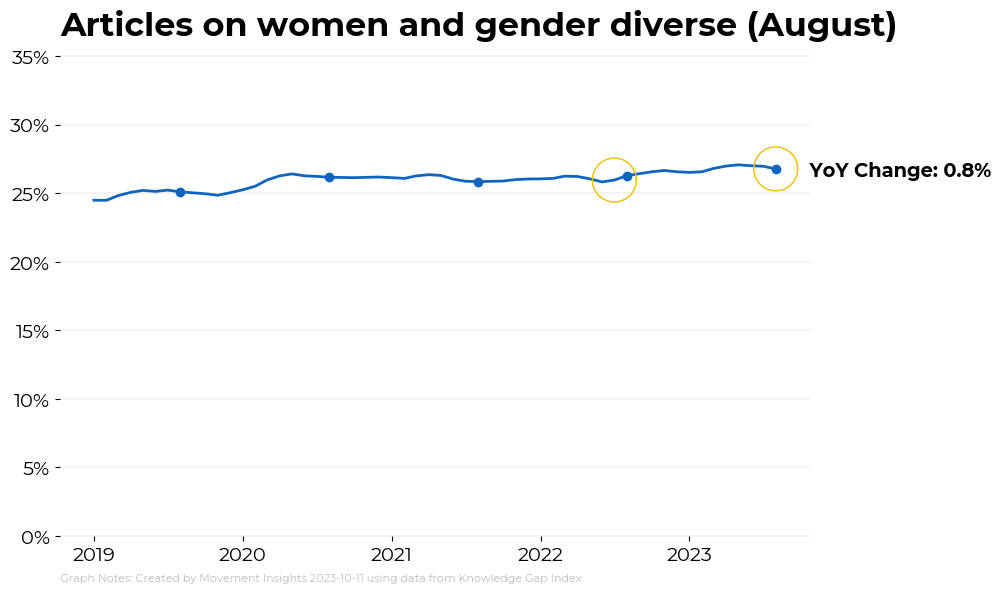

In [358]:
%run gender_gap_plot.ipynb